In [1]:
import sys
import os
ref_path = r"D:\OneDrive\References\Farahani_ALS-main\codes"## https://github.com/netneurolab/Farahani_ALS/tree/main/codes
sys.path.append(ref_path)

import random
import warnings
import numpy as np
import pandas as pd
import scipy.stats as stats
from pyls import behavioral_pls
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from neuromaps.images import dlabel_to_gifti
from netneurotools import datasets as nntdata
from neuromaps.images import load_data
from functions import (show_on_surface,
                        parcel2fsLR,
                        save_gifti,
                        load_nifti,
                        save_parcellated_data_in_Schaefer_forVis)
from pls_func import (plot_loading_bar,
                        plot_scores_and_correlations_unicolor)
from globals import path_results, path_fig, path_atlas, path_sc, nnodes
from scipy.io import loadmat
from scipy.io import savemat

In [2]:
version = '80_v2' ## PLS analysis index
epicenter_version='4modes_dataHansenSSC'  ## Epicenter map index

# Load epicenter maps of subjects
tmp  = loadmat(f'D:\\OneDrive\\5_TMS_response\\data_cud\\epicenterMap_avgranking_v{version}_{epicenter_version}_S4007Net.mat')
epicenterMaps = tmp['epiMaps']

# Load behavioral data of subjects
tmp =  loadmat(f'D:\\OneDrive\\5_TMS_response\\data_cud\\\phenos_TMS_v{version}_{epicenter_version}.mat')
pheno = tmp['phenos_hat']

In [3]:
X = epicenterMaps
Y = pheno
X = stats.zscore(X, axis = 0) # Brain
Y = stats.zscore(Y, axis = 0) # Behavior


#------------------------------------------------------------------------------
#                            PLS analysis - main
#------------------------------------------------------------------------------

nspins = 1000
num_subjects = len(X)
spins = np.zeros((num_subjects, nspins))
np.random.seed(1234)
for spin_ind in range(nspins):
    spins[:,spin_ind] = np.random.permutation(range(0, num_subjects))
spins = spins.astype(int)

pls_result = behavioral_pls(X,
                            Y,
                            n_boot = 1000,
                            n_perm = nspins,
                            permsamples = spins,
                            test_size=0,
                            seed = 2345)

# covariance between epicenter maps and clinical scores accounted by the latent variables 
varexp=pls_result.varexp

# results of premutation testing
permres=pls_result.permres
pvals=permres.pvals
permsamples=permres.permsamples
# results of bootstrap resampling
bootres=pls_result.bootres
# results of cross-validation
cvres=pls_result.cvres
values = pls_result.y_loadings[:,0]


In [4]:
## Somatosensory-Motor Dysconnectivity Spans Multiple Transdiagnostic Dimensions of Psychopathology
# we computed Pearson’s correlations  between the original behavioral measures and
# behavioral  composite scores for each LC (57,58).  A large positive (or  negative) 
# correlation for a particular behavioral measure for a  given LC indicates greater 
# importance of the behavioral measure for the LC.
from scipy.stats import pearsonr
y_scores=pls_result.y_scores

n_cols = Y.shape[1]
y_loadings_corrs = np.zeros(n_cols)
y_loadings_pvals = np.zeros(n_cols)
for i in range(n_cols):
    r, p = pearsonr(Y[:, i], y_scores[:, 0])
    y_loadings_corrs[i] = r
    y_loadings_pvals[i] = p

df = pd.DataFrame(y_loadings_corrs)
df.to_csv("y_loadings_corr.csv", index=False)
np.savetxt("y_scores.csv", y_scores, delimiter=",", fmt="%.6f")
np.savetxt("y_loadings.csv", pls_result.y_loadings, delimiter=",", fmt="%.6f")

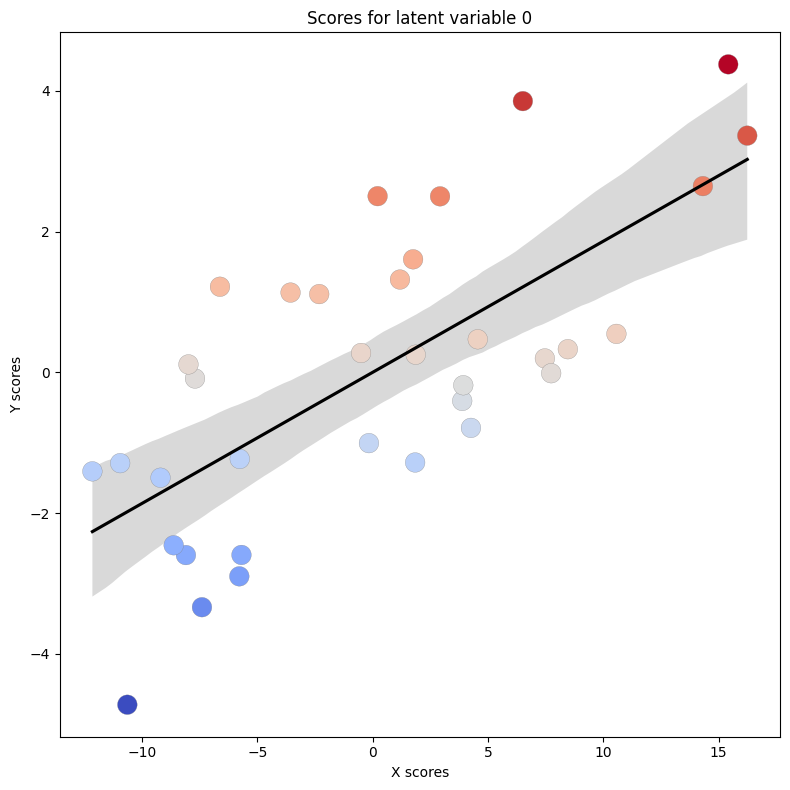

x-score and y-score Spearman correlation for latent variable 0:                 0.6627
x-score and y-score Pearson correlation for latent variable 0:                 0.7028


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib.patches as mpatches

tmpdir= f"D:\\OneDrive\\5_TMS_response\\PLS_behaviors_Epicenter\\Loading_plots_v{version}_epicenterMap_v{epicenter_version}"
os.makedirs(tmpdir, exist_ok=True)

# visualization of the first component, because these components are significant
for lv in [0]:
        plt.figure(figsize = (8, 8))
        plt.title(f'Scores for latent variable {lv}')
        sns.regplot(x = pls_result['x_scores'][:, lv],
                y = pls_result['y_scores'][:, lv],
                scatter = False,
                line_kws={'color': 'black'})
        color_data = -pls_result['y_scores'][:, lv]
        color_data = (color_data - np.min(color_data)) / (np.max(color_data) - np.min(color_data))*2-1

        sns.scatterplot(x = pls_result['x_scores'][:, lv],
                        y = pls_result['y_scores'][:, lv],
                        c = color_data,
                        s = 200,
                        cmap = 'coolwarm_r',
                        vmin = -1,
                        vmax = 1,
                        edgecolor='gray',
                        linewidth = 0.2)

        plt.xlabel('X scores')
        plt.ylabel('Y scores')
        plt.tight_layout()
        plt.savefig(tmpdir + '/score_xy_' + str(lv) + '_.svg',
        bbox_inches = 'tight',
        dpi = 300,
        transparent = True)
        plt.show()

        # Calculate and print score correlations
        score_correlation_spearmanr = spearmanr(pls_result['x_scores'][:, lv],
                                                pls_result['y_scores'][:, lv])
        score_correlation_pearsonr = pearsonr(pls_result['x_scores'][:, lv],
                                                pls_result['y_scores'][:, lv])

        print(f'x-score and y-score Spearman correlation for latent variable {lv}: \
                {score_correlation_spearmanr.correlation:.4f}')
        print(f'x-score and y-score Pearson correlation for latent variable {lv}: \
                {score_correlation_pearsonr[0]:.4f}')

In [8]:
#------------------------------------------------------------------------------
# Loading plots
#------------------------------------------------------------------------------
# Generate plots for the [0] latent variables, because these components are significant
# Read behavioral names 
from collections import defaultdict

df_groups = pd.read_csv(f"D:\\OneDrive\\4_PLS_behaviors\\data_cud\\bhvs_group_keyword_v{version}.csv")
# Define column groups
column_groups = defaultdict(list)
for _, row in df_groups.iterrows():
    column_groups[row["keyword"]].append(row["group"])
column_groups = dict(column_groups)
print(column_groups)

combined_columns = [column
                    for columns in column_groups.values()
                    for column in columns]
print(combined_columns)
# Create a dictionary to map groups to colors
group_colors = {'ASI'        : 'darksalmon',
                'BIS'        : 'sandybrown',
                'CCQN'       : 'rosybrown',
                'VAS'        : 'rosybrown',
                'MINI'       : 'goldenrod',
                'SCL90'      : 'salmon',
                'WHODAS'     : 'salmon',
                'Bio'        : 'darkgray'}
desired_group_order = ['BIS', 'SCL90', 'MINI', 'CCQN', 'VAS', 'Education']

{'BIS': ['cog', 'mot', 'nonp'], 'CCQN': ['ccqn.score'], 'VAS': ['vas'], 'SCL90': ['gsi', 'psdi', 'pst'], 'MINI': ['MINI.A8.MDE.past', 'MINI.B.DYSTHIM', 'MINI.C.SUICIDE', 'MINI.K.ABUSE.actual', 'MINI.P5.GAD', 'MINI.W.ADHD.adult'], 'Bio': ['education']}
['cog', 'mot', 'nonp', 'ccqn.score', 'vas', 'gsi', 'psdi', 'pst', 'MINI.A8.MDE.past', 'MINI.B.DYSTHIM', 'MINI.C.SUICIDE', 'MINI.K.ABUSE.actual', 'MINI.P5.GAD', 'MINI.W.ADHD.adult', 'education']


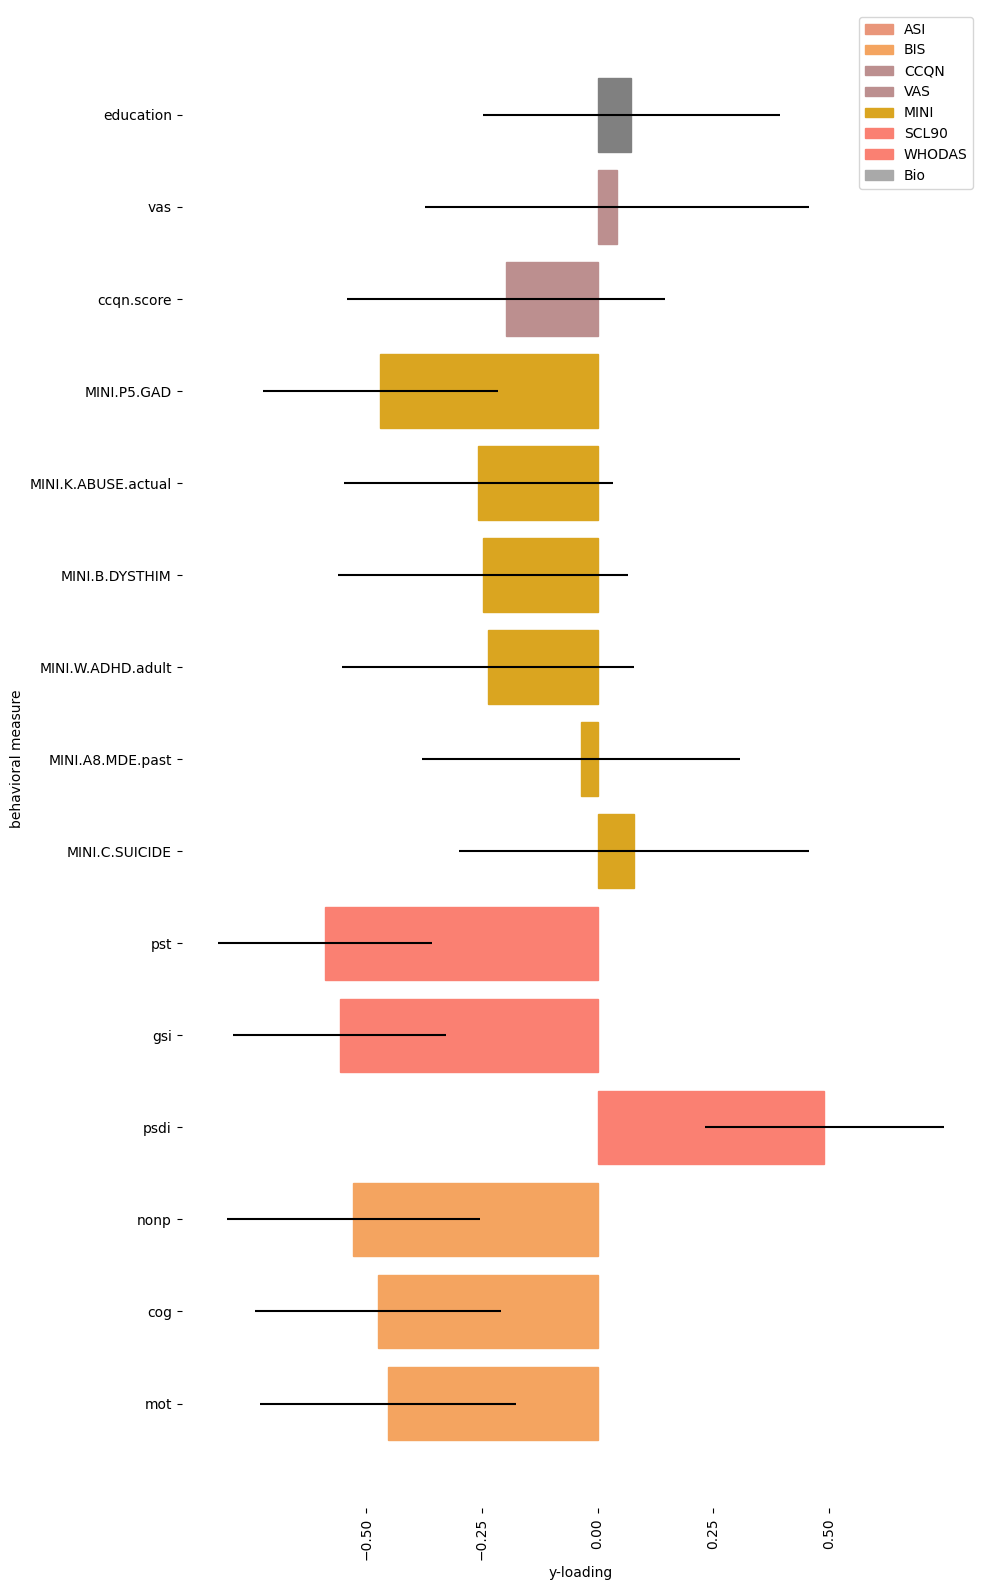

In [9]:
for lv in [0]:
    plot_loading_bar(lv,
                pls_result,
                combined_columns,
                desired_group_order,
                column_groups,
                group_colors,
                -0.5,
                0.5,
                f'D:\\OneDrive\\5_TMS_response\\PLS_behaviors_Epicenter\\Loading_plots_v{version}_epicenterMap_v{epicenter_version}\\',
                'epicenter_based_sorted')
    
#get X loadings for TMS dataset

xload = behavioral_pls(Y,
                       X,
                       n_boot = 1000,
                       n_perm = 0,
                       test_split = 0,
                       seed = 2345)

for lv in [0]:
    weights_cortex = xload.y_loadings
    #save as mat files 
    filename = f"D:\\OneDrive\\5_TMS_response\\PLS_behaviors_Epicenter\\Loading_plots_v{version}_epicenterMap_v{epicenter_version}\\Xloading.mat"
    data_to_save = {"xloadings": weights_cortex}
    savemat(filename, data_to_save)

PearsonRResult(statistic=0.7028172667414568, pvalue=2.5105869559440122e-06)
PearsonRResult(statistic=0.7028172667414568, pvalue=2.5105869559440122e-06)
pval is (for lv = 0): 0.0266666667


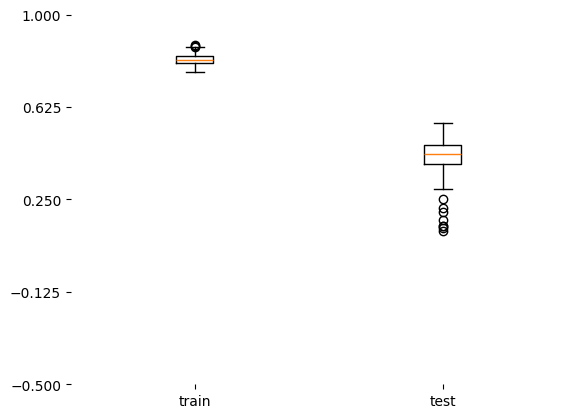

In [4]:
#------------------------------------------------------------------------------
# Cross-validation for the PLS analysis
#------------------------------------------------------------------------------
n_splits = 2 # 2-fold
np.random.seed(2345)
lv = 0
nperm  = 150
def cv_cal(X, Y):
    corr_test = np.zeros((n_splits, nperm))
    corr_train = np.zeros((n_splits, nperm))

    for iter_ind in range(nperm):
        kf = KFold(n_splits = n_splits, shuffle = True, random_state=iter_ind)
        c = 0
        for train_index, test_index in kf.split(X):

            Xtrain, Xtest = X[train_index], X[test_index]
            Ytrain, Ytest = Y[train_index], Y[test_index]

            train_result = behavioral_pls(Xtrain,
                                          Ytrain,
                                          n_boot = 0,
                                          n_perm = 0,
                                          test_split = 0,
                                          seed = 10)
            corr_train[c, iter_ind], _ = stats.pearsonr(train_result['x_scores'][:, lv],
                                            train_result['y_scores'][:, lv])

            # project weights, correlate predicted scores in the test set
            corr_test[c, iter_ind], _ = stats.pearsonr(Xtest @ train_result['x_weights'][:, lv],
                                   Ytest @ train_result['y_weights'][:, lv])
            c = c + 1
    return(corr_train, corr_test)

corr_train, corr_test = cv_cal(X,Y) 
print(stats.pearsonr(X @ pls_result['x_weights'][:, 0], Y @ pls_result['y_weights'][:, 0]))
print(stats.pearsonr(pls_result['x_scores'][:, 0], pls_result['y_scores'][:, 0]))

flat_train = np.mean(corr_train, axis=0).flatten()
flat_test  = np.mean(corr_test, axis=0).flatten()

combined_train_test = [flat_train, flat_test]
plt.boxplot(combined_train_test)
plt.xticks([1, 2], ['train', 'test'])

# Remove the box around the figure
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax = plt.gca()
y_ticks = np.linspace(-0.5, 1, num = 5)
ax.set_yticks(y_ticks)

outpath=f'D:\\OneDrive\\5_TMS_response\\PLS_behaviors_Epicenter\\Loading_plots_v{version}_epicenterMap_v{epicenter_version}\\'
plt.savefig(outpath + 'train_test_CV_' + str(lv) +'.pdf',
       bbox_inches = 'tight',
       dpi = 300,
       transparent = True)
plt.show()

#------------------------------------------------------------------------------
# Permutation
#------------------------------------------------------------------------------
def single_cv_cal(X, Y, val_random):
    corr_test = np.zeros((n_splits, 1))
    corr_train = np.zeros((n_splits, 1))
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = val_random)
    c = 0
    for train_index, test_index in kf.split(X):
        Xtrain, Xtest = X[train_index], X[test_index]
        Ytrain, Ytest = Y[train_index], Y[test_index]

        train_result = behavioral_pls(Xtrain,
                                      Ytrain,
                                      n_boot = 0,
                                      n_perm = 0,
                                      test_split = 0,
                                      seed = 2345)
        corr_train[c, 0], _ = stats.pearsonr(train_result['x_scores'][:, lv],
                                        train_result['y_scores'][:, lv])

        # project weights, correlate predicted scores in the test set
        corr_test[c, 0], _ = stats.pearsonr(Xtest @ train_result['x_weights'][:, lv],
                               Ytest @ train_result['y_weights'][:, lv])
        c = c + 1
    return(corr_train.flatten(), corr_test.flatten())

per_train_corr = np.zeros((n_splits, nperm))
per_test_corr = np.zeros((n_splits, nperm))

num_subjects = len(X)
perms_y = np.zeros((num_subjects, nperm))

for perm_ind in range(nperm):
    perms_y[:, perm_ind] = np.random.permutation(range(0, num_subjects))

for perm_ind in range(nperm):
    tempy = perms_y[:, perm_ind].astype(int)
    Y_permuted = Y[tempy]

    per_train_corr[:, perm_ind], per_test_corr[:, perm_ind] = single_cv_cal(X, Y_permuted, perm_ind)
    #print(perm_ind)
    
flat_train = np.mean(corr_train, axis=0).flatten()
flat_test  = np.mean(corr_test, axis=0).flatten()   
#flat_train = corr_train[0, :].flatten()
#flat_test  = corr_test[0, :].flatten()

flat_train_per = np.mean(per_train_corr, axis=0).flatten()
flat_test_per  = np.mean(per_test_corr, axis=0).flatten()  
#flat_train_per = per_train_corr[0, :].flatten()
#flat_test_per  = per_test_corr[0, :].flatten()

p_val = (np.count_nonzero(flat_test_per  > np.median(flat_test))) / (nperm)
print(f'pval is (for lv = {lv}): {p_val:.10f}')



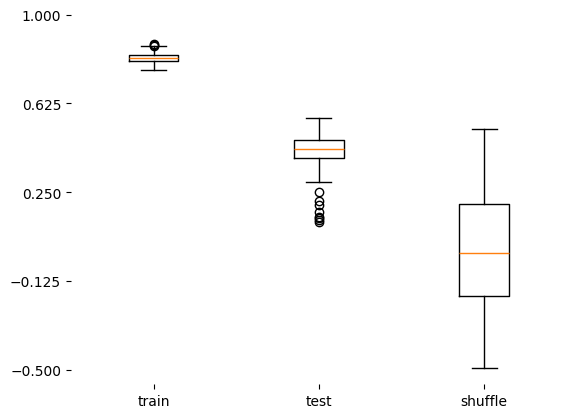

In [5]:
combined_train_test_shuffle = [flat_train, flat_test, flat_test_per]

plt.boxplot(combined_train_test_shuffle)
plt.xticks([1, 2, 3], ['train', 'test','shuffle'])

# Remove the box around the figure
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax = plt.gca()
y_ticks = np.linspace(-0.5, 1, num = 5)
ax.set_yticks(y_ticks)

outpath=f'D:\\OneDrive\\5_TMS_response\\PLS_behaviors_Epicenter\\Loading_plots_v{version}_epicenterMap_v{epicenter_version}\\'
plt.savefig(outpath + 'train_test_shuffle_CV_' + str(lv) +'.pdf',
       bbox_inches = 'tight',
       dpi = 300,
       transparent = True)
plt.show()